In this notebook, we visualize the data patterns and create a quick and dirty model to predict the temperature.

In [1]:
import os
import pandas as pd
import numpy as np

def combine_csv(folder_path, test_condition):
    """
    Combine all CSV files in a folder into a single DataFrame.
    :param folder_path: Path to the folder containing the CSV files
    :param seq_idx: Sequence index
    :param label: Label of the sequence (Normal - 0, Abnormal - 1)
    :return: A single DataFrame containing all the data from the CSV files
    """

    # Get a list of all CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Create an empty DataFrame to store the combined data
    combined_df = pd.DataFrame()

    # Iterate over the CSV files in the folder
    for file in csv_files:
        # Construct the full path to each CSV file
        file_path = os.path.join(folder_path, file)

        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Drop the time. Will add later.
        df = df.drop(labels=df.columns[0], axis=1)

        # Remove outliers by defining ranges.
        remove_outliers(df)        

        # Extract the file name (excluding the extension) to use as a prefix
        file_name = os.path.splitext(file)[0]

        # Add a prefix to each column based on the file name
        df = df.add_prefix(f'{file_name}_')

        # Concatenate the current DataFrame with the combined DataFrame
        combined_df = pd.concat([combined_df, df], axis=1)

    df = pd.read_csv(file_path)
    combined_df = pd.concat([df['time'], combined_df], axis=1)
    combined_df.loc[:, 'test_condition'] = test_condition

    return combined_df


def remove_outliers(df: pd.DataFrame):
    ''' Remove outliers from the dataframe based on defined valid ranges.
    Use ffil function.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 200, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].ffill()       

In [2]:
# Read the data
# path_training = [
#     '20240105_164214',
#     '20240105_165300',
#     '20240105_165972',
#     '20240320_152031',
#     '20240320_153841',
#     '20240320_155664'
# ]

path_header = '../../robot_digital_twin/condition_monitoring_matlab_ros/matlab_application/collected_data/'
path_data = os.listdir(path_header)
path_data = path_data[:-1]

df_data = pd.DataFrame()
for tmp_path in path_data:
    path = path_header + tmp_path
    tmp_df = combine_csv(path, tmp_path)
    df_data = pd.concat([df_data, tmp_df])
    df_data = df_data.reset_index(drop=True)

20240105_164214



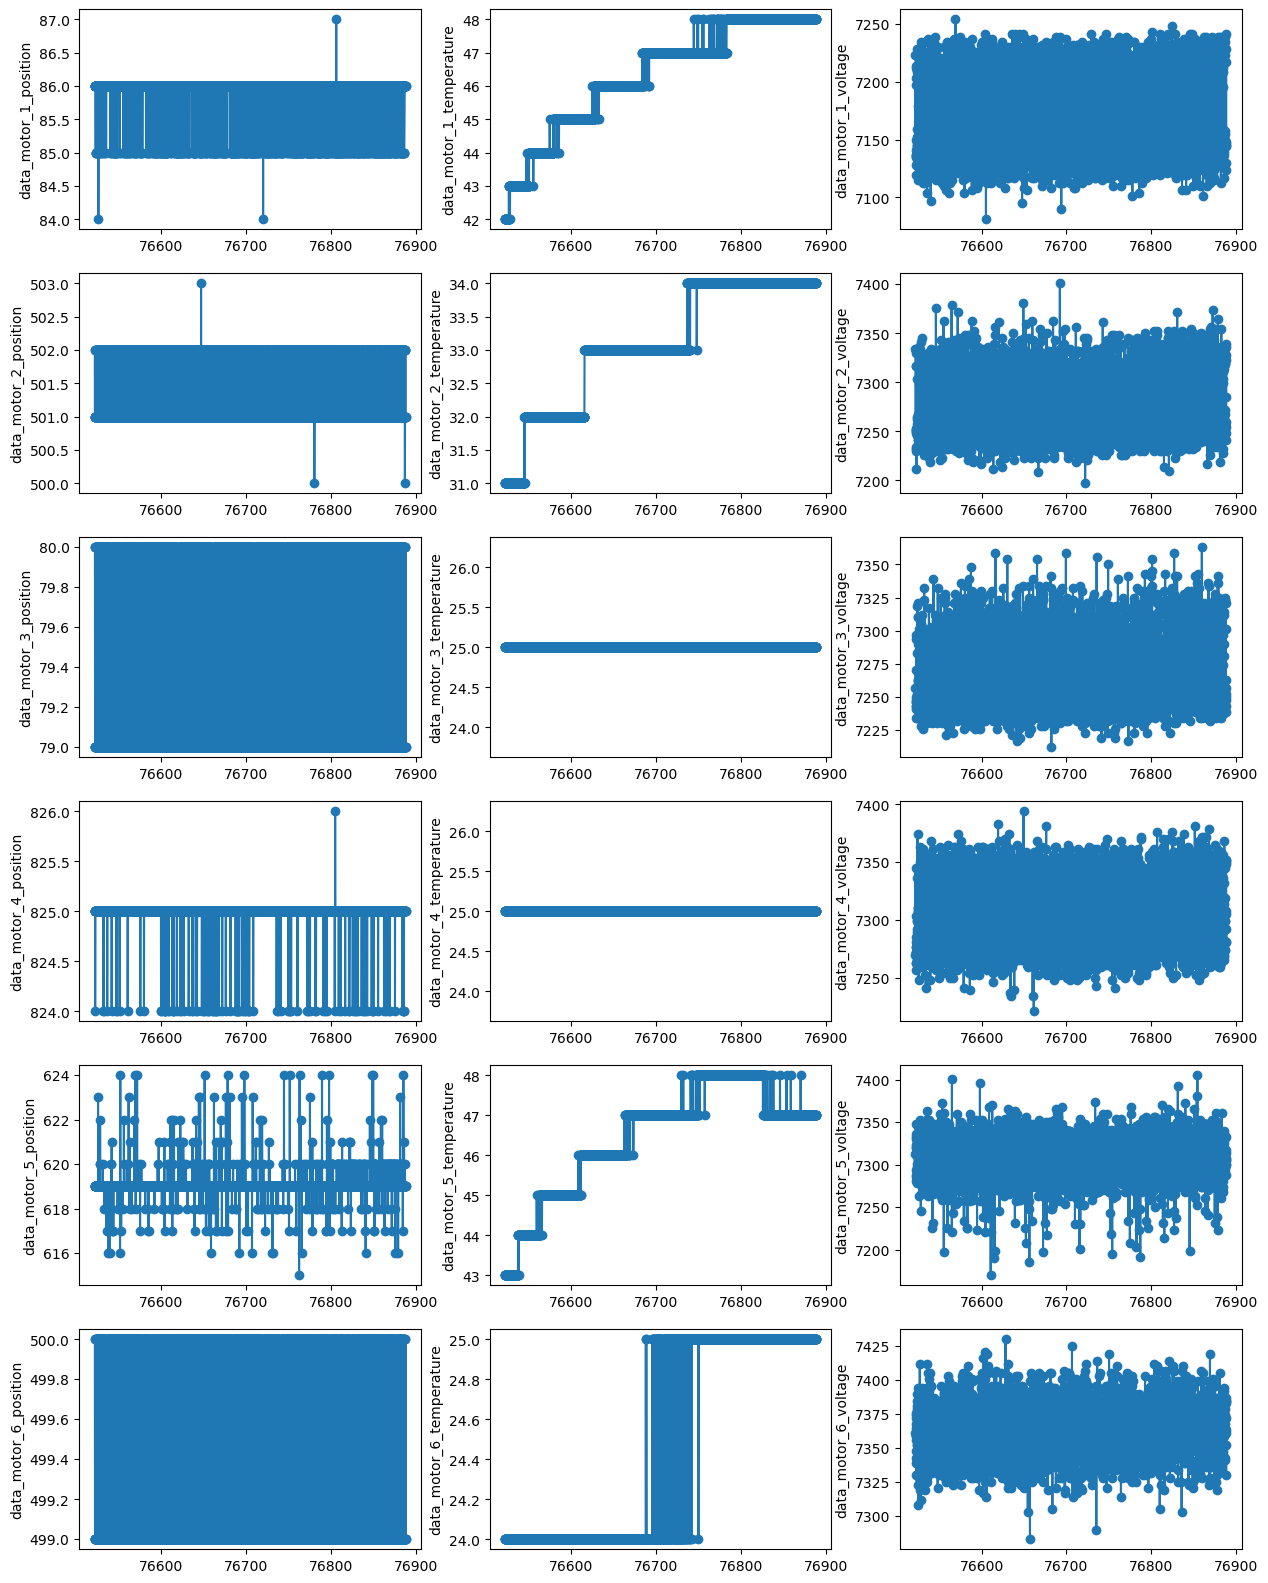

20240105_165300



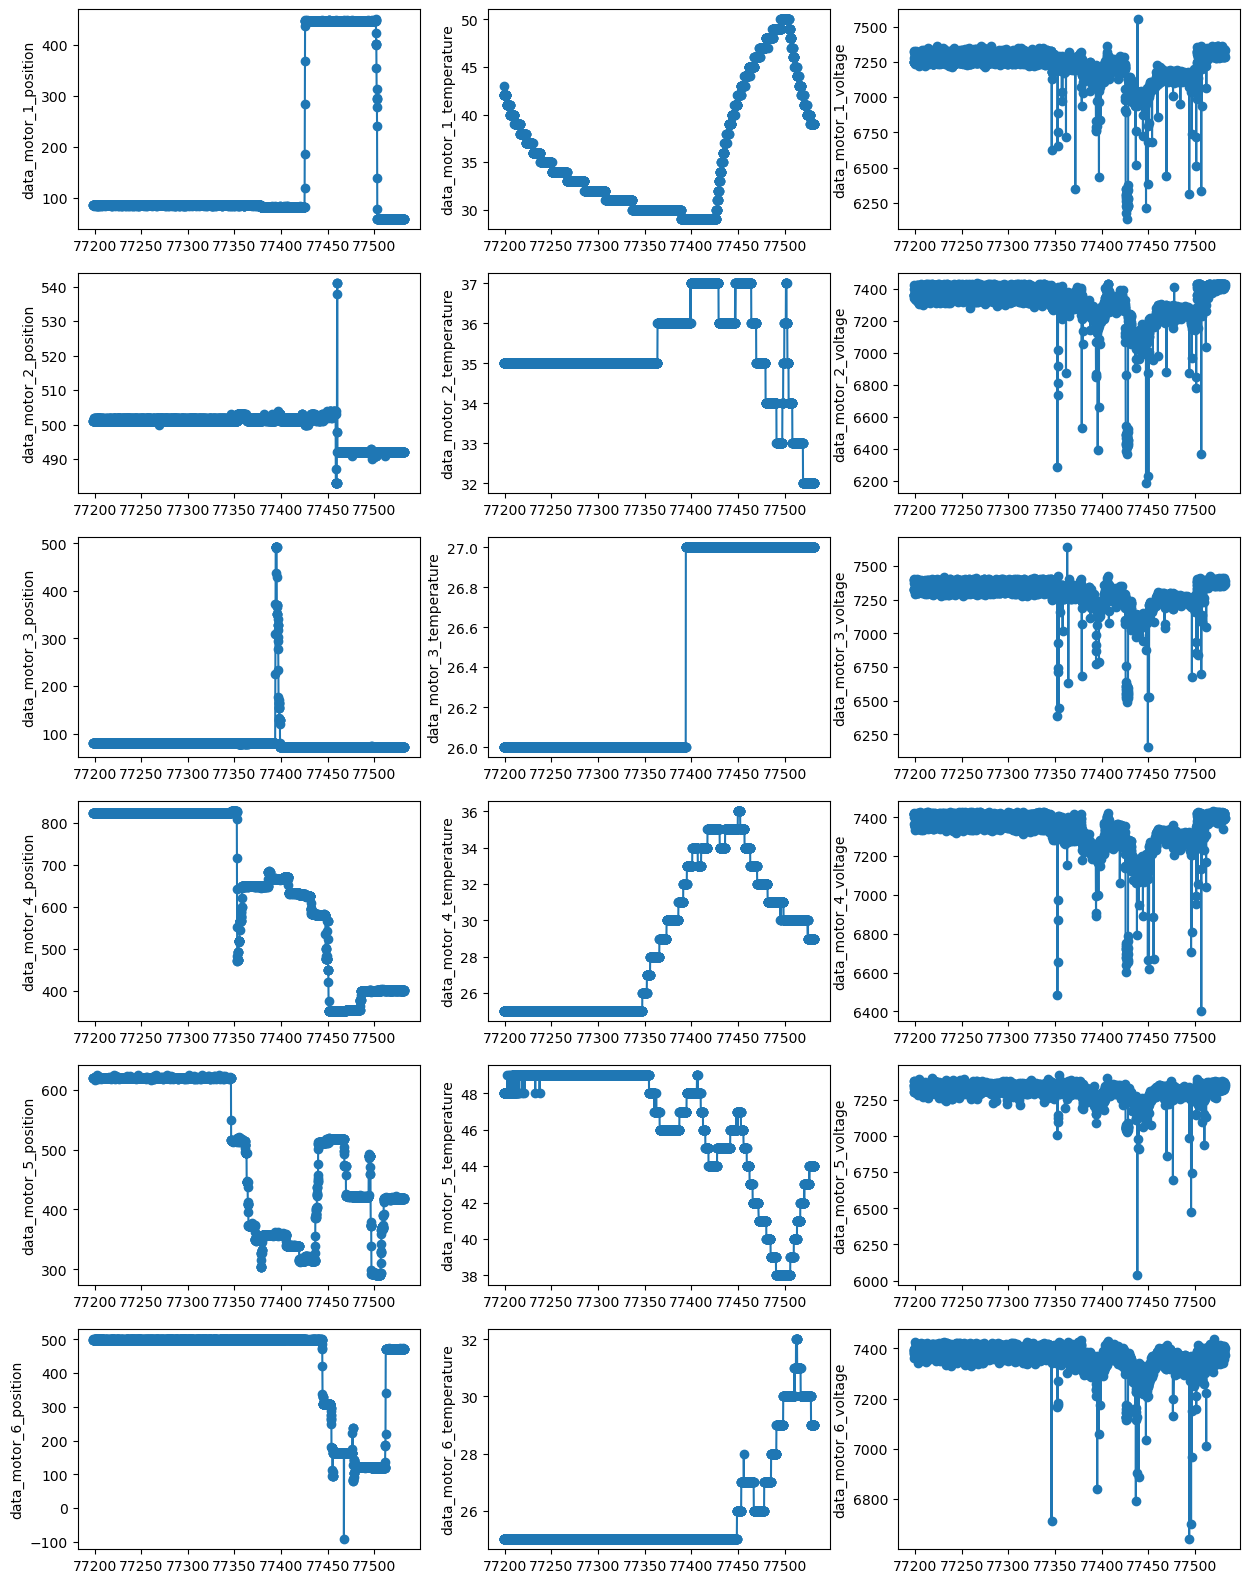

20240105_165972



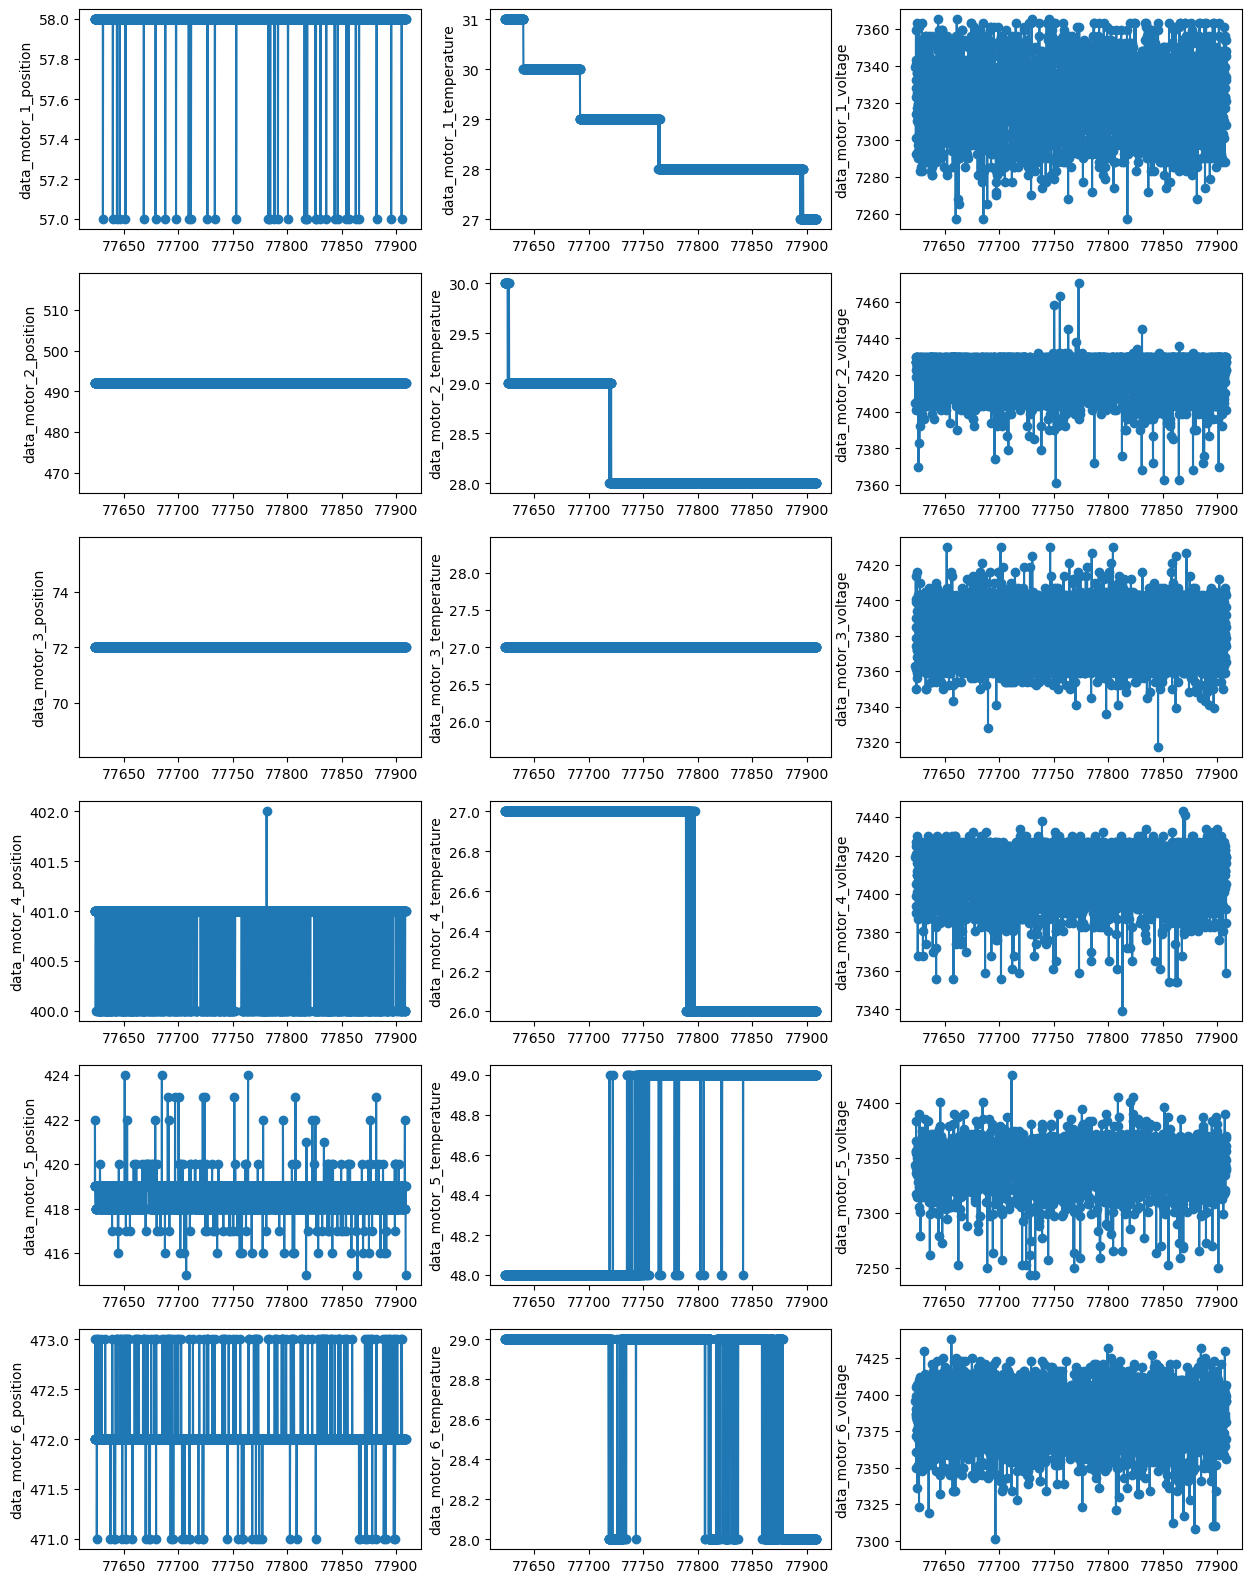

20240320_152031



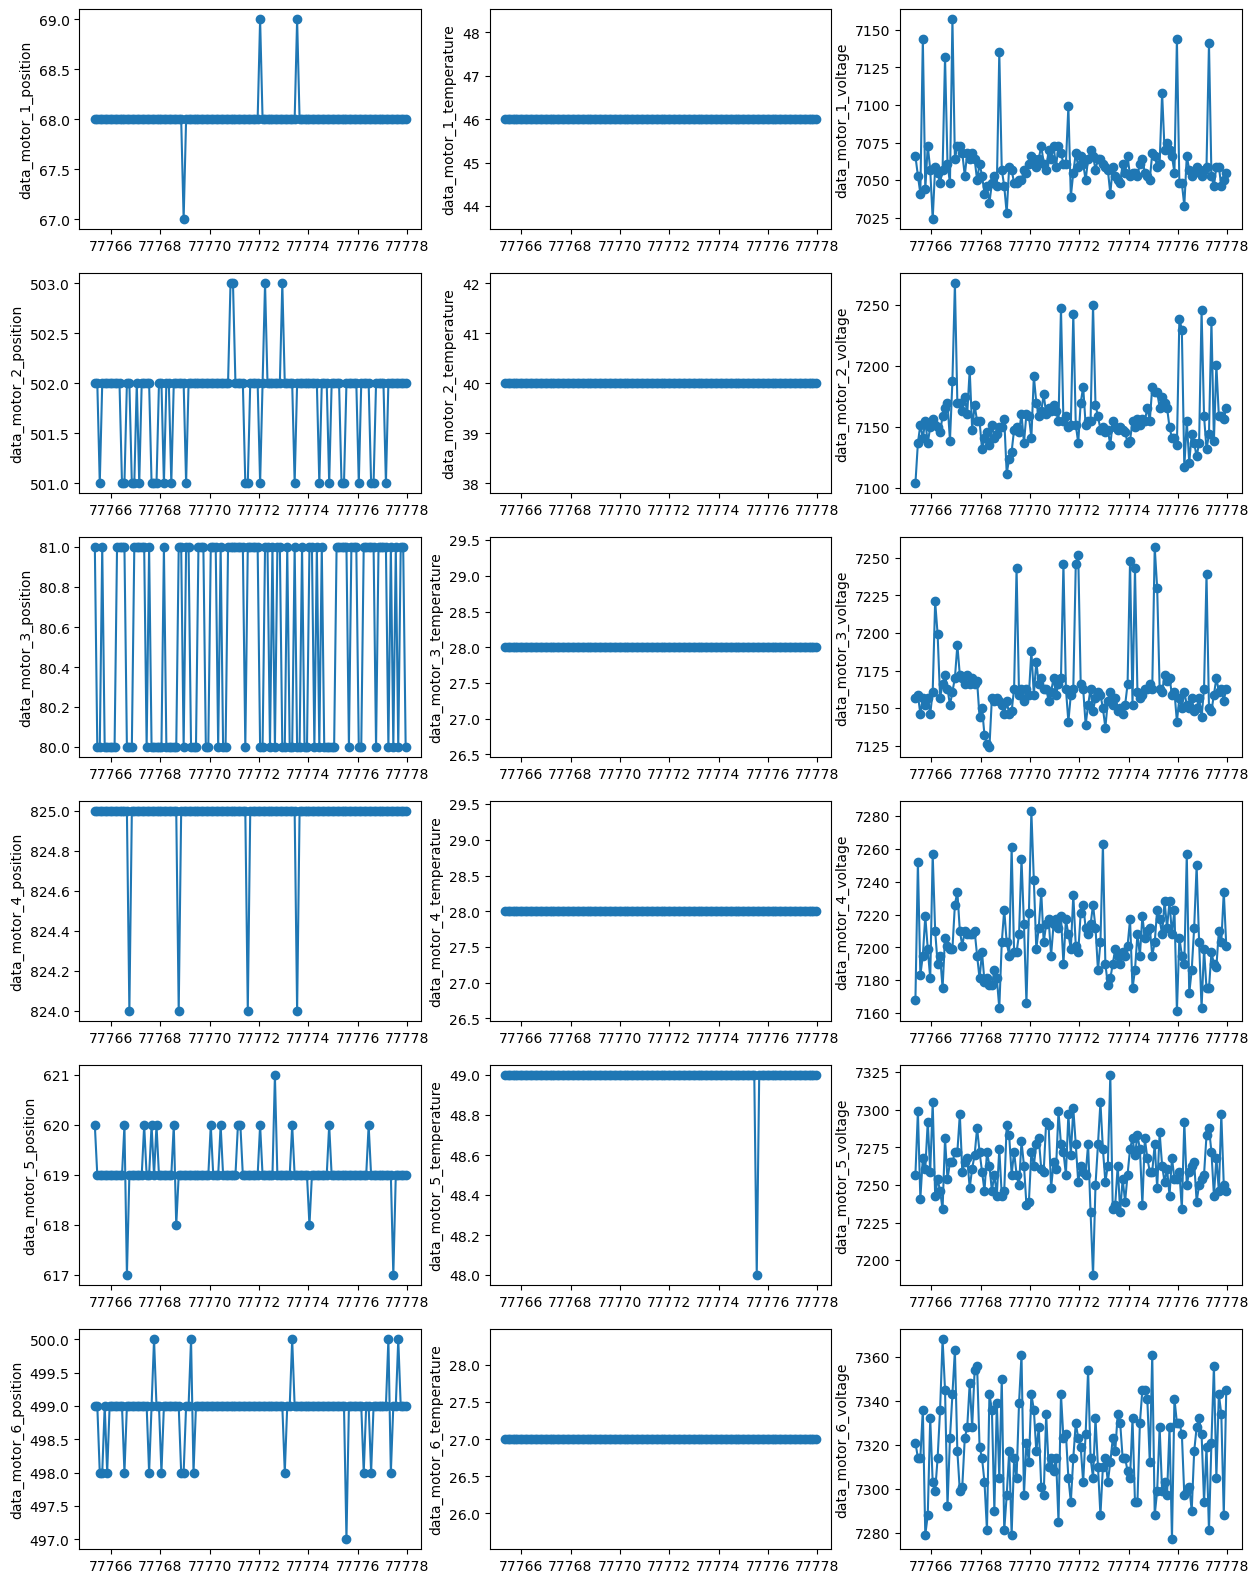

20240320_153841



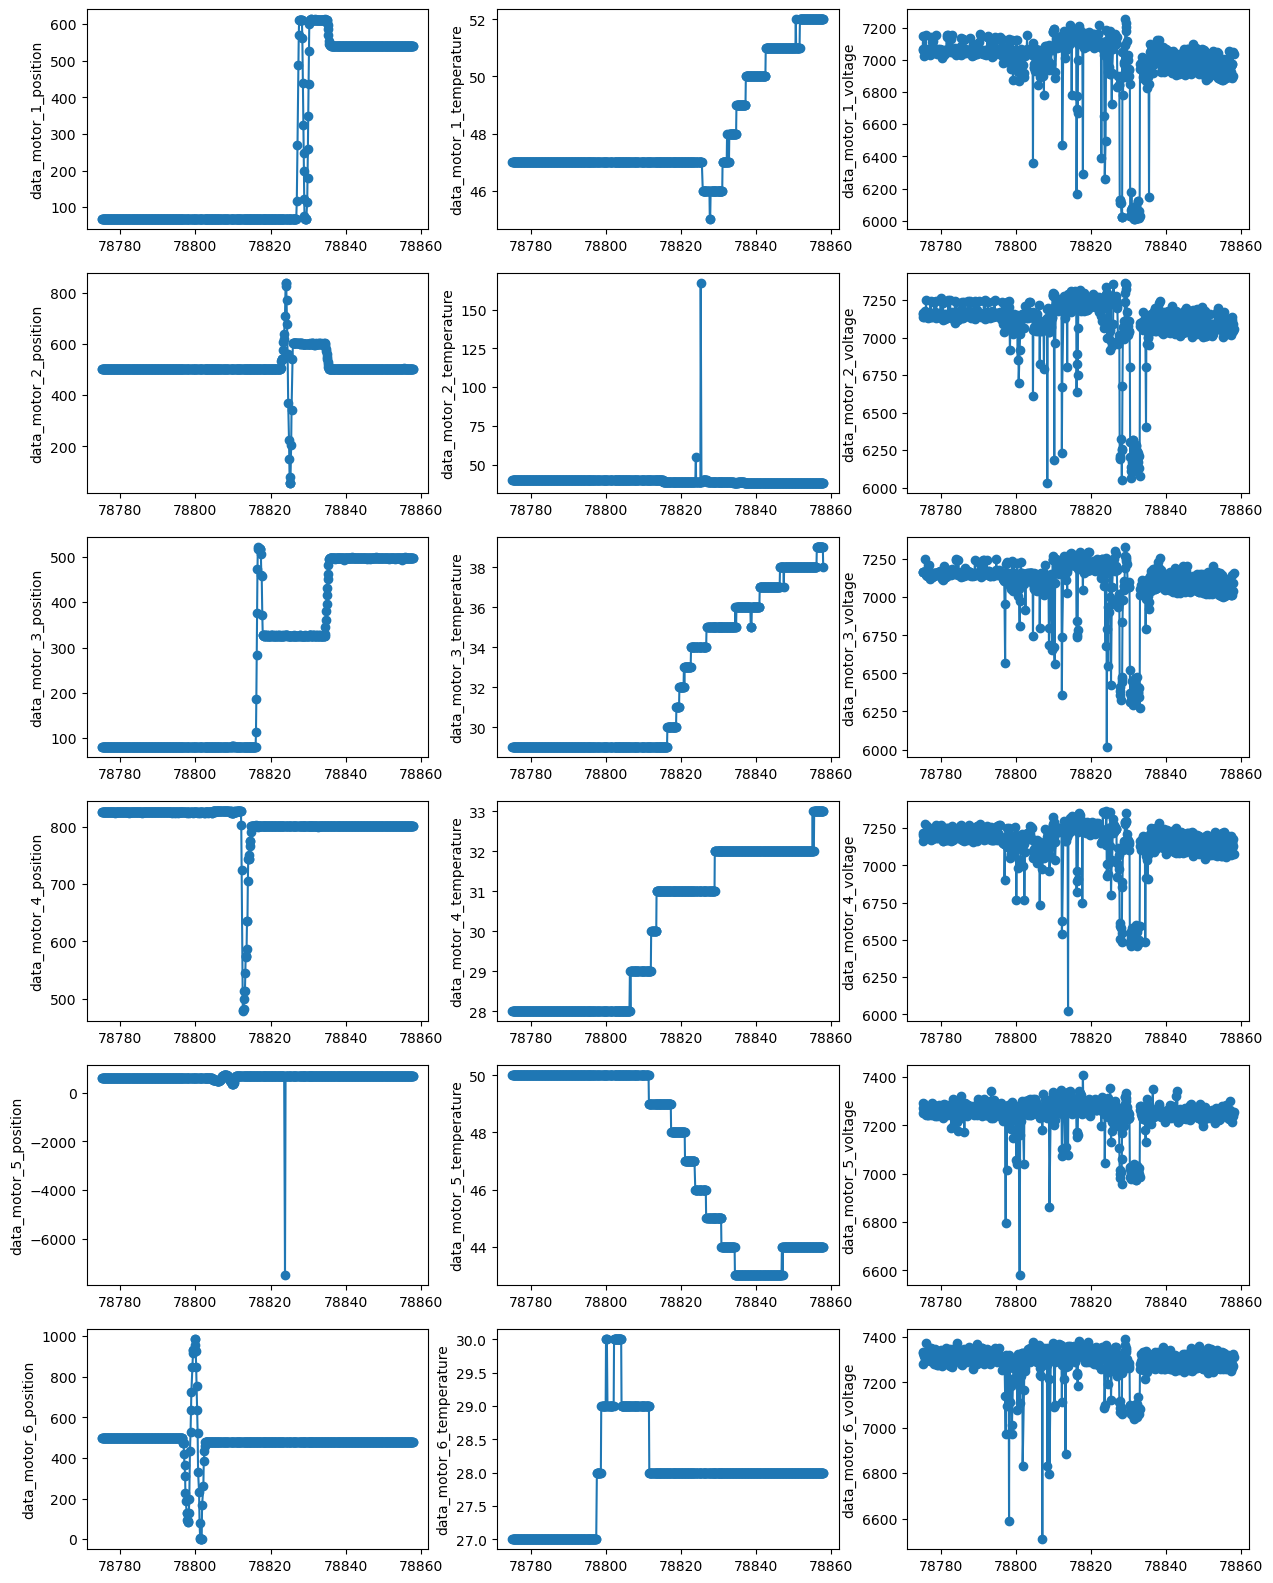

20240320_155664



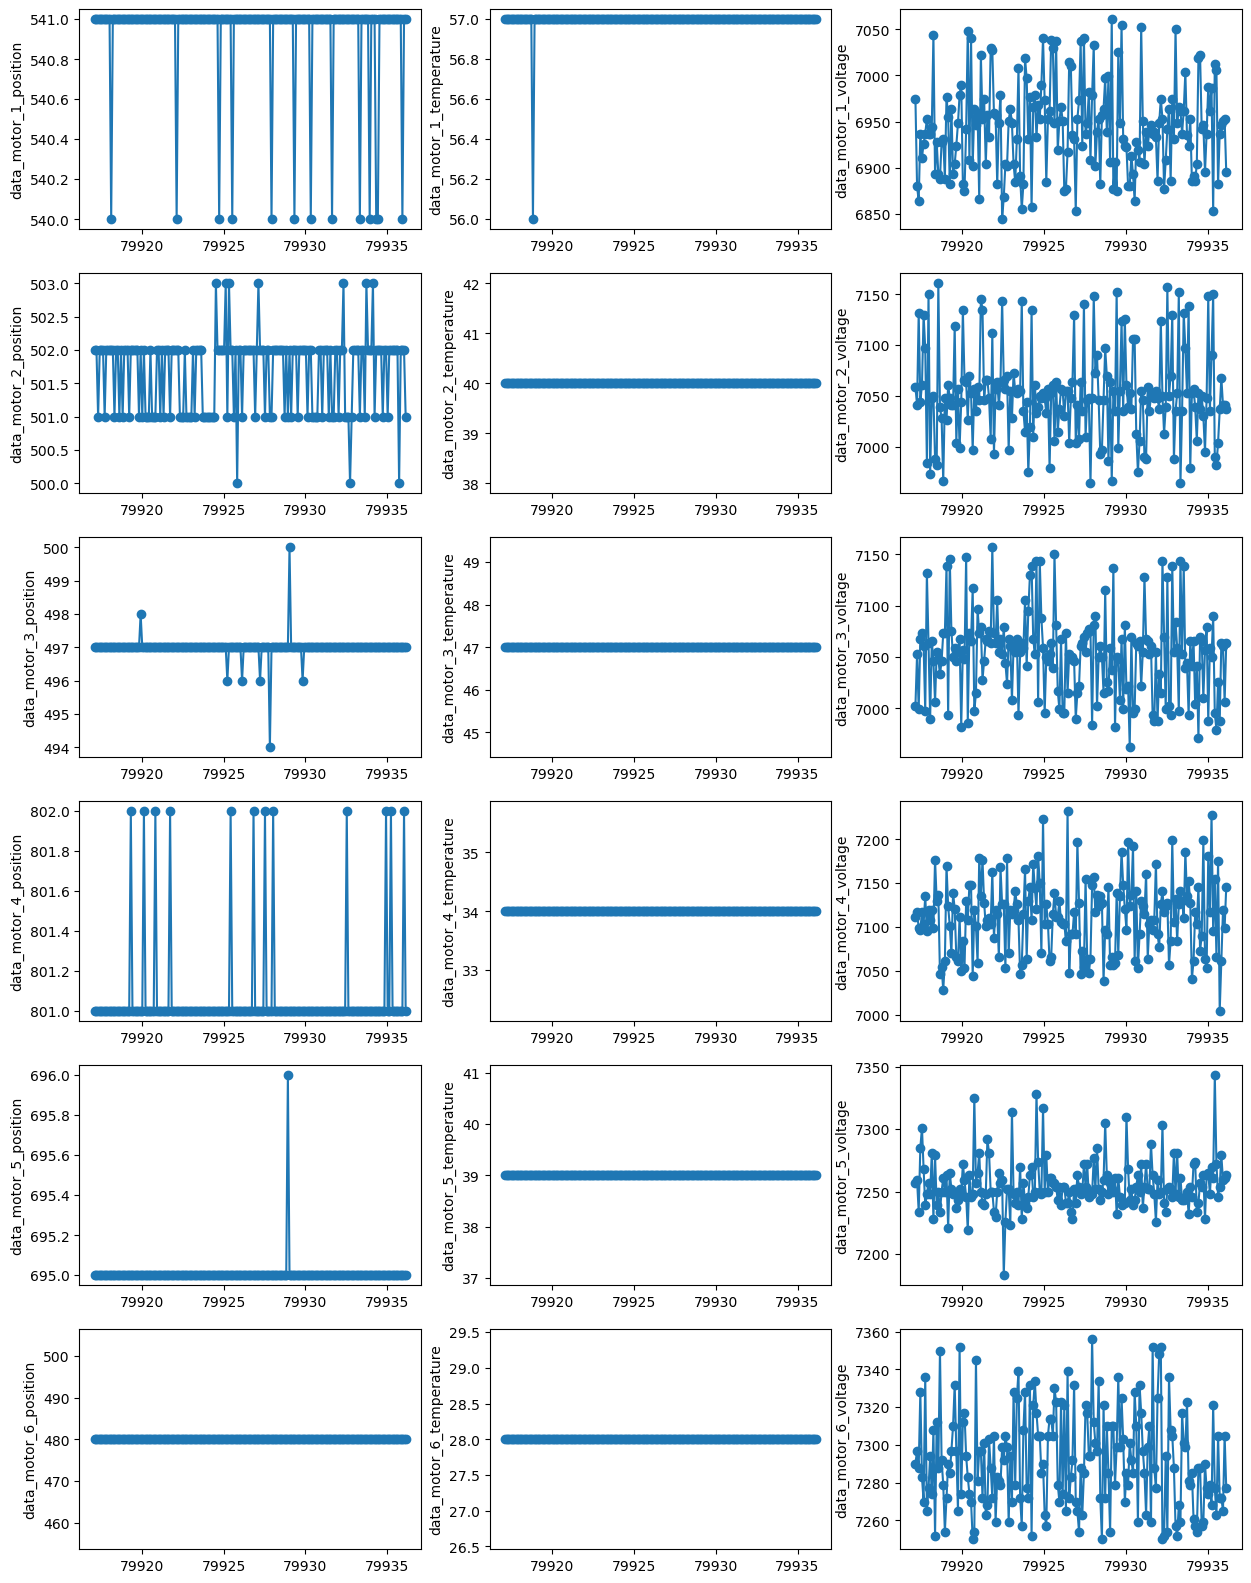

20240321_122650



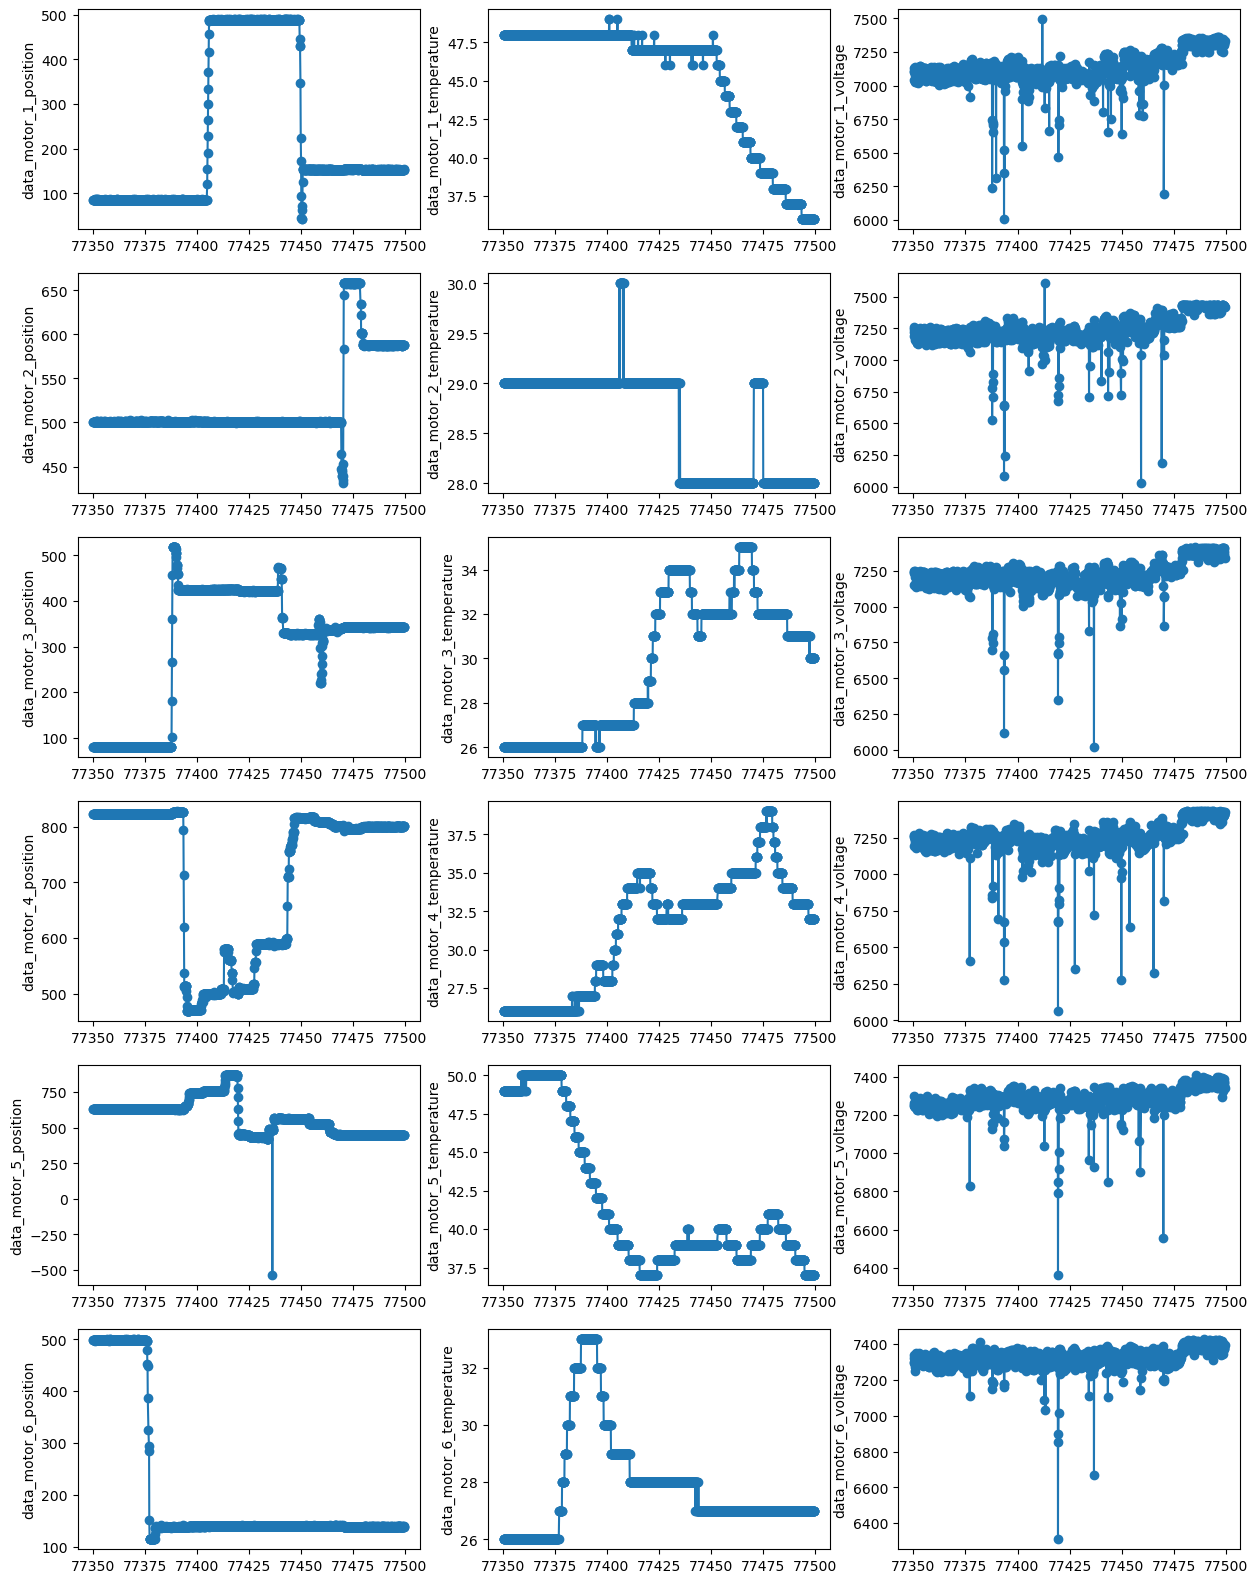

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Change the file name to the one you want to visualize.
for selected_sequence_idx in path_data:
    filtered_df = df_data[df_data['test_condition'] == selected_sequence_idx]

    print(selected_sequence_idx + '\n')

    fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))
    for ax, col in zip(axes.flat, ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage', 
        'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
        'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
        'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
        'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
        'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']):
        ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
        ax.set_ylabel(col)

    plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler

df_data_processed = df_data.drop(columns=['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label',
                                        'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label', 'test_condition'])

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler to the data and transform the data
df_data_processed = pd.DataFrame(data=scaler.fit_transform(df_data_processed), columns=df_data_processed.columns)

<Axes: >

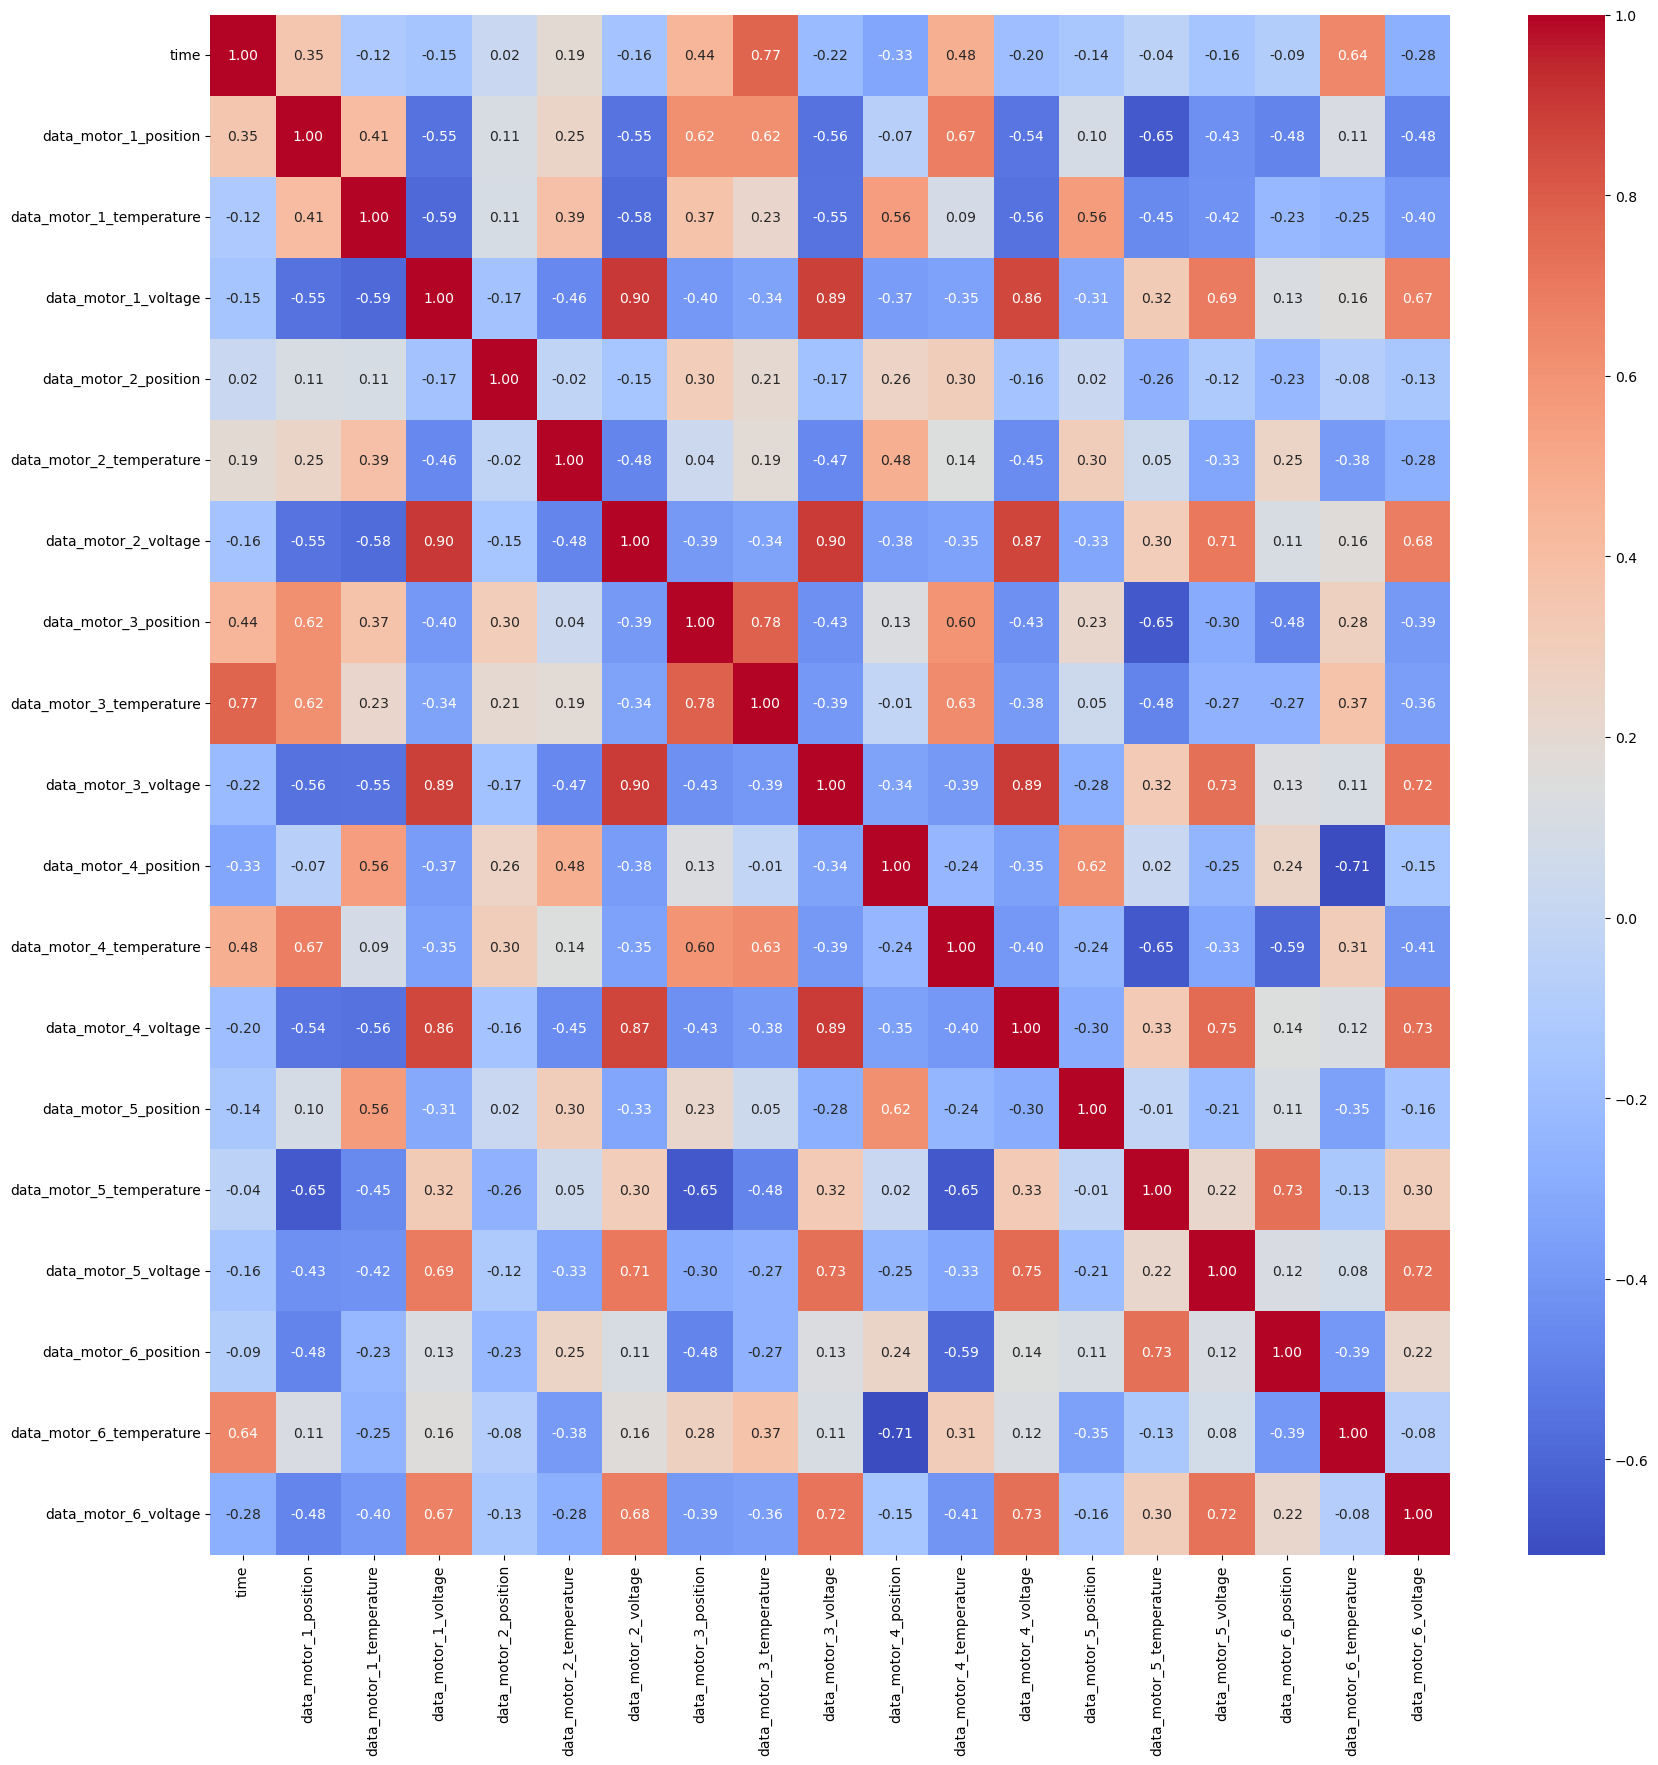

In [14]:
import pandas as pd
import seaborn as sns

# Compute correlation matrix
correlation_matrix = df_data_processed.corr()

# Plot correlation matrix using seaborn
plt.figure(figsize=(20, 20))  # Adjust width and height as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [35]:
y_name = 'data_motor_1_temperature'

df_x = df_data.drop(columns=['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label',
                    'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label'])
df_x = df_x.drop(columns=[y_name])
df_x.columns

y = df_data.loc[:, y_name]

In [36]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler_x = StandardScaler()

# Fit scaler to the data and transform the data
df_x_transformed = pd.DataFrame(data=scaler_x.fit_transform(df_x), columns=df_x.columns)

In [37]:
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error

def run_reg_mdl(reg_mdl, X_tr, y_tr, X_test, y_test, is_cv = False):  
    # Training the regression model.    
    reg_mdl = reg_mdl.fit(X_tr, y_tr)

    # Prediction
    y_pred_tr = reg_mdl.predict(X_tr)
    y_pred = reg_mdl.predict(X_test)
    # Transform back
    # y_pred_tr = scaler_y.inverse_transform(y_pred_tr)
    # y_pred = scaler_y.inverse_transform(y_pred)
    # y_tr = scaler_y.inverse_transform(y_tr)

    if not is_cv:
        model_pef(y_tr, y_test, y_pred_tr, y_pred)

    return reg_mdl, y_pred_tr, y_pred


''' This subfunction checks the performance of the fitted model on both the training and testing dataset. '''
def model_pef(y_tr, y_test, y_pred_tr, y_pred):
    # Plot the predicted and truth.
    # Training data set.
    fig_1 = plt.figure(figsize = (16,6))
    ax = fig_1.add_subplot(1,2,1) 
    ax.set_xlabel('True', fontsize = 15)
    ax.set_ylabel('Prediction', fontsize = 15)
    ax.set_title('Prediction V.S. the truth on the training dataset', fontsize = 20)
    ax.plot(y_tr[np.abs(y_tr-y_pred_tr) > 3], y_pred_tr[np.abs(y_tr-y_pred_tr) > 3], 'xr')
    ax.plot(y_tr[np.abs(y_tr-y_pred_tr) <= 3], y_pred_tr[np.abs(y_tr-y_pred_tr) <= 3], 'ob')

    # Testing data set.
    ax = fig_1.add_subplot(1,2,2) 
    ax.set_xlabel('True', fontsize = 15)
    ax.set_ylabel('Prediction', fontsize = 15)
    ax.set_title('Prediction V.S. the truth on the testing dataset', fontsize = 20)
    ax.plot(y_test[np.abs(y_test-y_pred) > 3], y_pred[np.abs(y_test-y_pred) > 3], 'xr')
    ax.plot(y_test[np.abs(y_test-y_pred) <= 3], y_pred[np.abs(y_test-y_pred) <= 3], 'ob')
    
    # Plot the residual errors.
    # Training data set.
    fig = plt.figure(figsize = (16,6))
    ax = fig.add_subplot(1,2,1) 
    ax.set_xlabel('Index of the data points', fontsize = 15)
    ax.set_ylabel('Residual error', fontsize = 15)
    ax.set_title('Residual errors on the training dataset', fontsize = 20)
    ax.plot(y_pred_tr - y_tr, 'o')
    ax.hlines([3, -3], 0, len(y_tr), linestyles='dashed', colors='r')

    # Testing data set.
    ax = fig.add_subplot(1,2,2) 
    ax.set_xlabel('Index of the data points', fontsize = 15)
    ax.set_ylabel('Residual error', fontsize = 15)
    ax.set_title('Residual errors on the testing dataset', fontsize = 20)
    ax.plot(y_pred-y_test, 'o')
    ax.hlines([3, -3], 0, len(y_test), linestyles='dashed', colors='r')

    # Plot the distribution of residual errors.
    # Training data set.
    fig = plt.figure(figsize = (16,6))
    ax = fig.add_subplot(1,2,1) 
    ax.set_xlabel('Residual error', fontsize = 15)
    ax.set_ylabel('Counts', fontsize = 15)
    ax.set_title('Distribution of residual errors (training)', fontsize = 20)
    ax.hist(y_pred_tr - y_tr)
    ax.axvline(x=3, linestyle='--', color='r')
    ax.axvline(x=-3, linestyle='--', color='r')

    # Testing data set.
    ax = fig.add_subplot(1,2,2) 
    ax.set_xlabel('Residual error', fontsize = 15)
    ax.set_ylabel('Counts', fontsize = 15)
    ax.set_title('Distribution of residual errors (testing)', fontsize = 20)
    ax.hist(y_pred-y_test)
    ax.axvline(x=3, linestyle='--', color='r')
    ax.axvline(x=-3, linestyle='--', color='r')

    # Performance indicators
    # Show the model fitting performance.
    print('Training performance, max error is: ' + str(max_error(y_tr, y_pred_tr ) ))
    print('Training performance, mean root square error is: ' + str(mean_squared_error(y_tr, y_pred_tr ,  squared=False)))
    print('Training performance, residual error > 3psi (%): ' + str(sum(abs(y_tr - y_pred_tr)>3)/y_tr.shape[0]*100) + '%')

    print('Prediction performance, max error is: ' + str(max_error(y_pred, y_test)))
    print('Prediction performance, mean root square error is: ' + str(mean_squared_error(y_pred, y_test, squared=False)))
    print('Prediction performance, residual error > 3psi: (%) ' + str(sum(abs(y_pred - y_test)>3)/y_test.shape[0]*100) + '%')

    return

Training performance, max error is: 115.89228435192923
Training performance, mean root square error is: 1.75348716751669
Training performance, residual error > 3psi (%): 4.5304312777106%
Prediction performance, max error is: 115.89228435192923
Prediction performance, mean root square error is: 1.75348716751669
Prediction performance, residual error > 3psi: (%) 4.5304312777106%


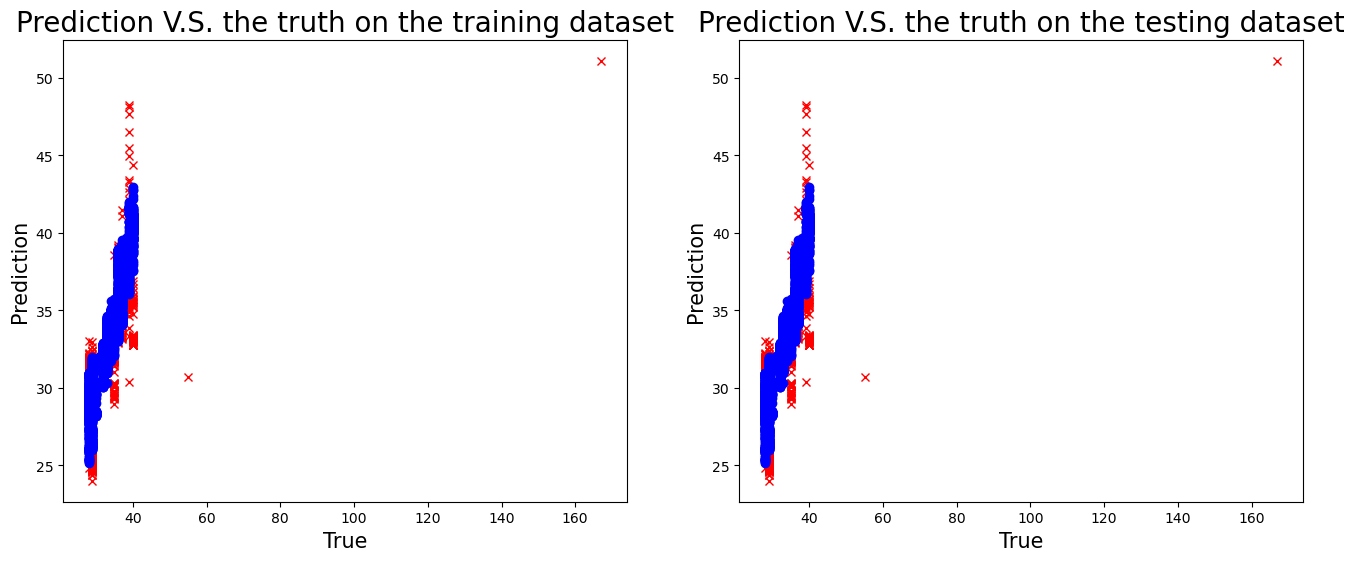

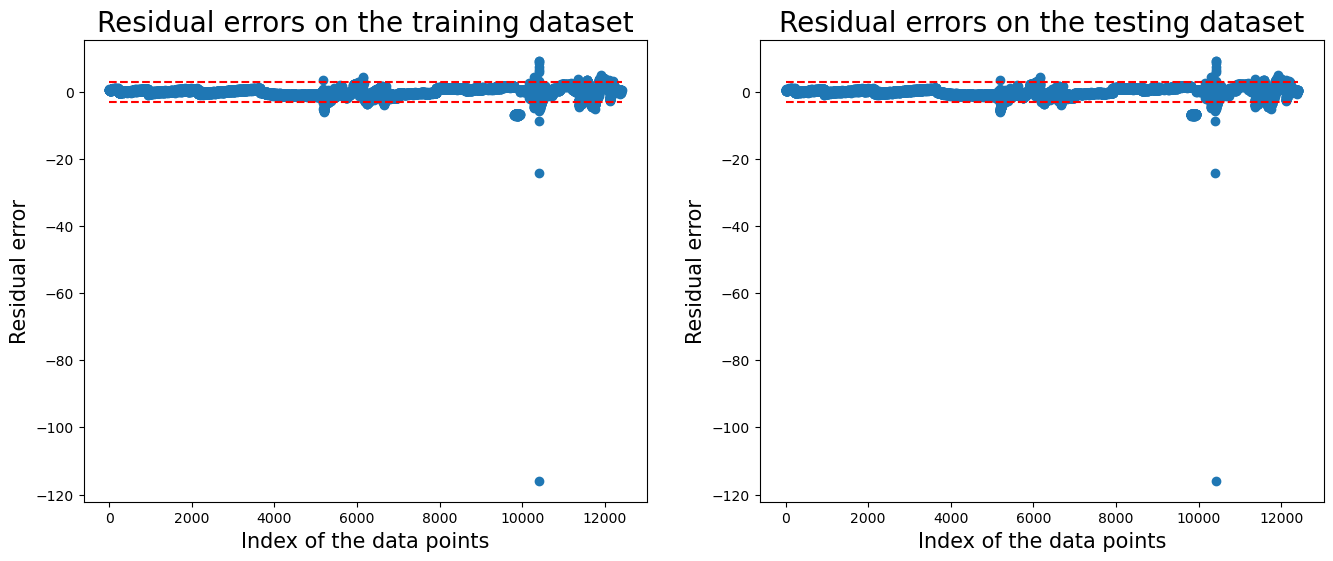

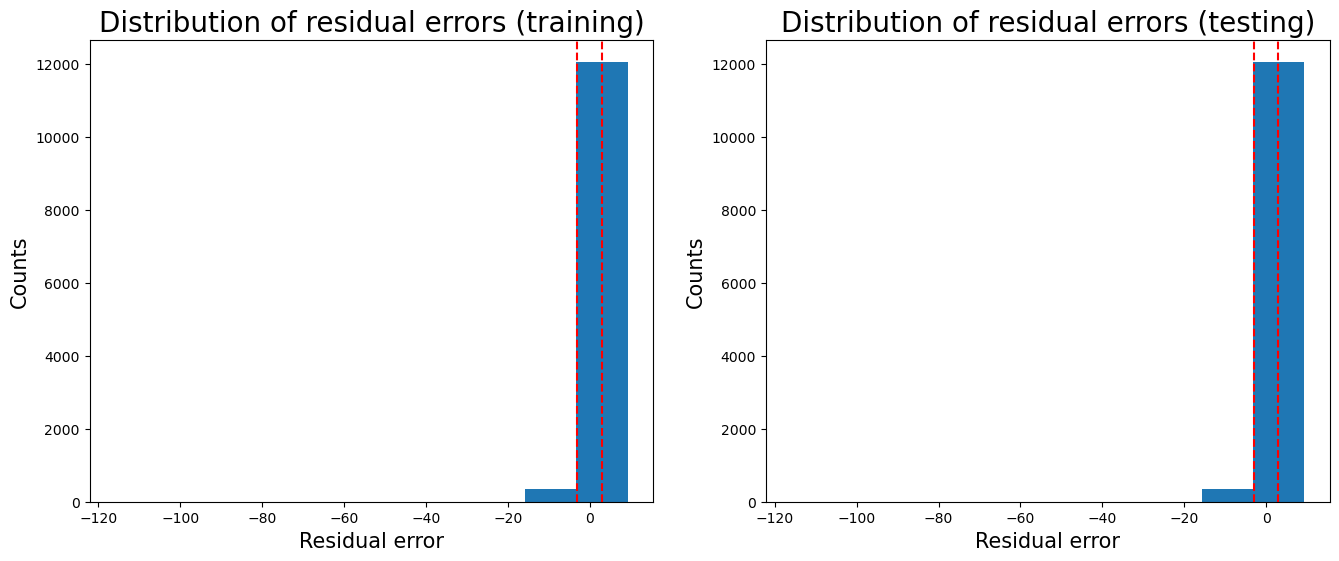

In [38]:
from sklearn.linear_model import LinearRegression

reg_mdl = LinearRegression()

reg_mdl, y_pred_tr, y_pred = run_reg_mdl(reg_mdl, df_x_transformed, y, df_x_transformed, y)